In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import obonet
import random
import torch
import math
from Bio import SeqIO
import Bio.PDB
import urllib.request
import py3Dmol
import pylab
import pickle as pickle
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GAE
from torch_geometric.nn import GATConv
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn.models import MLP
from torch_geometric.data import Data
from torch_geometric.nn.pool import SAGPooling
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
class CFG:
    pdbfiles: str = "/home/paul/BioHack/pdbind-refined-set/"

In [4]:
def remove_hetatm(input_pdb_file, output_pdb_file):
    # Open the input PDB file for reading and the output PDB file for writing
    with open(input_pdb_file, 'r') as infile, open(output_pdb_file, 'w') as outfile:
        for line in infile:
            # Check if the line starts with 'HETATM' (non-protein atoms)
            if line.startswith('HETATM'):
                continue  # Skip this line (HETATM record)
            # Write all other lines to the output file
            outfile.write(line)
            
def get_atom_types_from_sdf(sdf_file):
    supplier = Chem.SDMolSupplier(sdf_file)
    atom_types = set()

    for mol in supplier:
        if mol is not None:
            atoms = mol.GetAtoms()
            atom_types.update([atom.GetSymbol() for atom in atoms])

    return sorted(list(atom_types))

def get_atom_types_from_mol2_split(mol2_file):
    atom_types = set()

    with open(mol2_file, 'r') as mol2:
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip() == '@<TRIPOS>BOND':
                break

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 5:
                    atom_type = parts[5]
                    atom_types.add(atom_type)
    
    atom_types_split = set()
    for atom in atom_types:
        atom_types_split.add(str(atom).split('.')[0])
        

    return sorted(list(atom_types_split))

def get_atom_types_from_mol2(mol2_file):
    atom_types = set()

    with open(mol2_file, 'r') as mol2:
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip() == '@<TRIPOS>BOND':
                break

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 5:
                    atom_type = parts[5]
                    atom_types.add(atom_type)

    return sorted(list(atom_types))

def get_atom_list_from_mol2_split(mol2_file):
    atoms = []
    with open(mol2_file, 'r') as mol2:
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip() == '@<TRIPOS>BOND':
                break

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 5:
                    atom_type = parts[5]
                    atoms.append(atom_type)
    
    atom_list = []
    for atom in atoms:
        atom_list.append(str(atom).split('.')[0])
        

    return atom_list

def get_atom_list_from_mol2(mol2_file):
    atoms = []
    with open(mol2_file, 'r') as mol2:
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip() == '@<TRIPOS>BOND':
                break

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 5:
                    atom_type = parts[5]
                    atoms.append(atom_type)

    return atoms

def get_bond_types_from_mol2(mol2_file):
    bond_types = set()

    with open(mol2_file, 'r') as mol2:
        reading_bonds = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>BOND':
                reading_bonds = True
                continue
            elif reading_bonds and line.strip().startswith('@<TRIPOS>'):
                break

            if reading_bonds:
                parts = line.split()
                if len(parts) >= 4:
                    bond_type = parts[3]
                    bond_types.add(bond_type)

    return sorted(list(bond_types))

def read_mol2_bonds(mol2_file):
    bonds = []
    bond_types = []

    with open(mol2_file, 'r') as mol2:
        reading_bonds = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>BOND':
                reading_bonds = True
                continue
            elif reading_bonds and line.strip().startswith('@<TRIPOS>'):
                break

            if reading_bonds:
                parts = line.split()
                if len(parts) >= 4:
                    atom1_index = int(parts[1])
                    atom2_index = int(parts[2])
                    bond_type = parts[3]
                    bonds.append((atom1_index, atom2_index))
                    bond_types.append(bond_type)

    return bonds, bond_types

def calc_residue_dist(residue_one, residue_two) :
    """Returns the C-alpha distance between two residues"""
    diff_vector  = residue_one["CA"].coord - residue_two["CA"].coord
    return np.sqrt(np.sum(diff_vector * diff_vector))

def calc_dist_matrix(chain_one, chain_two) :
    """Returns a matrix of C-alpha distances between two chains"""
    answer = np.zeros((len(chain_one), len(chain_two)), float)
    for row, residue_one in enumerate(chain_one) :
        for col, residue_two in enumerate(chain_two) :
            answer[row, col] = calc_residue_dist(residue_one, residue_two)
    return answer

def calc_contact_map(uniID,map_distance):
    pdb_code = uniID
    pdb_filename = uniID+"_pocket_clean.pdb"
    structure = Bio.PDB.PDBParser(QUIET = True).get_structure(pdb_code, (CFG.pdbfiles +'/'+pdb_code+'/'+pdb_filename))
    model = structure[0]
    flag1 = 0
    flag2 = 0
    idx = 0
    index = []
    chain_info = []
    
    for chain1 in model:
        for resi in chain1:
            index.append(idx)
            idx += 1
            chain_info.append([chain1.id,resi.id])
        for chain2 in model:
            if flag1 == 0:
                dist_matrix = calc_dist_matrix(model[chain1.id], model[chain2.id])
            else:
                new_matrix = calc_dist_matrix(model[chain1.id], model[chain2.id])
                dist_matrix = np.hstack((dist_matrix,new_matrix))
            flag1 += 1
        flag1 = 0
        if flag2 == 0:
            top_matrix = dist_matrix
        else:
            top_matrix = np.vstack((top_matrix,dist_matrix))
        flag2 += 1
    
    contact_map = top_matrix < map_distance
    return contact_map, index, chain_info


def one_hot_encode_single_res(res):
    allowed = set("GAVCPLIMWFKRHSTYNQDEUO")
    if not set(res).issubset(allowed):
        invalid = set(res) - allowed
        raise ValueError(f"Sequence has broken AA: {invalid}")
        
    AA_dict = {'GLY':torch.Tensor([1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'ALA':torch.Tensor([0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'VAL':torch.Tensor([0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'CYS':torch.Tensor([0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'PRO':torch.Tensor([0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'LEU':torch.Tensor([0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'ILE':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'MET':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'TRP':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'PHE':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'LYS':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'ARG':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'HIS':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'SER':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'THR':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0]),
               'TYR':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]),
               'ASN':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0]),
               'GLN':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0]),
               'ASP':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]),
               'GLU':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]),}
    return AA_dict[res]

AA_dictionary = {'GLY':torch.Tensor([1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'ALA':torch.Tensor([0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'VAL':torch.Tensor([0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'CYS':torch.Tensor([0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'PRO':torch.Tensor([0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'LEU':torch.Tensor([0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'ILE':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'MET':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'TRP':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'PHE':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'LYS':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'ARG':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'HIS':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'SER':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'THR':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0]),
            'TYR':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]),
            'ASN':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0]),
            'GLN':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0]),
            'ASP':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]),
            'GLU':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]),}

def uniID2graph(uniID,map_distance):
    atom_name = 'CA'
    node_feature = []
    edge_index = []
    edge_attr = []
    contact_map, index, chain_info = calc_contact_map(uniID,map_distance)
    pdb_code = uniID
    pdb_filename = uniID+"_pocket_clean.pdb"
    structure = Bio.PDB.PDBParser(QUIET = True).get_structure(pdb_code, (CFG.pdbfiles +'/'+pdb_code+'/'+pdb_filename))
    model = structure[0]
    
    for i in index:
        node_feature.append(one_hot_encode_single_res(model[chain_info[i][0]][chain_info[i][1]].get_resname()))
        for j in index:
            if contact_map[i,j] == 1:
                edge_index.append([i,j])
                diff_vector = model[chain_info[i][0]][chain_info[i][1]]['CA'].coord - model[chain_info[j][0]][chain_info[j][1]]['CA'].coord
                edge_feature = (np.sqrt(np.sum(diff_vector * diff_vector))/map_distance)        
                edge_attr.append(edge_feature)
                            
    edge_index = np.array(edge_index)
    edge_index = edge_index.transpose()
    edge_index = torch.Tensor(edge_index)
    edge_index = edge_index.to(torch.int64)
    edge_attr = torch.Tensor(edge_attr)
    node_feature = torch.stack(node_feature)
    graph = Data(x = node_feature, edge_index = edge_index,edge_attr = edge_attr)
    return graph

In [46]:
with open('AA_dict.pkl', 'rb') as f:
    AA_dict = pickle.load(f)

with open('atom_type_dict.pkl', 'rb') as f:
    atom_type_dict = pickle.load(f)

In [54]:
Embeddings = []
for i in AA_dict:
    new = np.hstack((AA_dict[i],np.zeros(25)))
    Embeddings.append(torch.Tensor(new))
for j in atom_type_dict:
    new = np.hstack((np.zeros(20),atom_type_dict[j]))
    Embeddings.append(torch.Tensor(new))

In [75]:
functions_tensor = torch.stack(Embeddings)
dataset = TensorDataset(functions_tensor)
dataloader = DataLoader(dataset, batch_size=15, shuffle=True)

In [56]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoded_size, num_layers=1, num_heads=1, hidden_size=10):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder_embedding = nn.Linear(input_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.encoder_fc = nn.Linear(hidden_size, encoded_size)
        
        # Decoder
        self.decoder_fc = nn.Linear(encoded_size, hidden_size)
        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.decoder_output = nn.Linear(hidden_size, input_size)
    
    def forward(self, x):
        # Encoding
        x = self.encoder_embedding(x)
        x = self.transformer_encoder(x)
        encoded = self.encoder_fc(x)
        
        # Decoding
        x = self.decoder_fc(encoded)
        x = self.transformer_decoder(x,encoded)
        decoded = self.decoder_output(x)
        
        return decoded
    
    def encode(self,x):
        x = self.encoder_embedding(x)
        x = self.transformer_encoder(x)
        encoded = self.encoder_fc(x)
        
        return encoded
    
    def dencode(self,encoded):
        x = self.decoder_fc(encoded)
        x = self.transformer_decoder(x,encoded)
        decoded = self.decoder_output(x)
        
        return decoded

In [89]:
autoencoder = Autoencoder(input_size = 45, encoded_size=20, num_layers=6,hidden_size = 20)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = autoencoder.to(DEVICE)

# Define a loss function (e.g., Mean Squared Error) and an optimizer (e.g., Adam)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1750], gamma=0.1)

# Training loop
num_epochs = 4000  # Adjust the number of epochs as needed
lowest = 0.0015
losses = []

dataloader = DataLoader(dataset, batch_size=15, shuffle=True)
dataloader_val = DataLoader(dataset, batch_size=1, shuffle=True)

for epoch in range(num_epochs):
    total_loss = 0.0
    val_loss = 0.0

    if epoch  == 1000:
        dataloader = DataLoader(dataset, batch_size=10, shuffle=True)      

    if epoch  == 2000:
        dataloader = DataLoader(dataset, batch_size=5, shuffle=True)  
    
    if epoch  == 3000:
        dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
    
    if epoch  == 3500:
        dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    for batch in dataloader:
        inputs = batch[0].to(DEVICE).float()
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = autoencoder(inputs)
        
        # Compute the loss
        loss = criterion(outputs, inputs)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        inputs= inputs.to('cpu')
        
        total_loss += loss.item()
        
    for batch in dataloader_val:
        with torch.no_grad():
            inputs = batch[0].to(DEVICE).float()
        
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
        
            inputs= inputs.to('cpu')
        
        val_loss += loss.item()
        
    # Print the average loss for this epoch
    avg_loss = total_loss / len(dataloader)
    avg_val_loss = val_loss / len(dataloader_val)
    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f} Val Loss: {avg_val_loss:.4f}')
    
    if avg_loss < 0.0015 and epoch > 3500:
        torch.save(autoencoder,('autoencoder_98var_10062023_'+str(epoch+1)))
        if lowest > avg_loss:
            lowest = avg_loss
            epoch_num = epoch+1
    
    #if epoch > 100:
        #torch.save(autoencoder,('autoencoder_98var_10062023_'+str(epoch)))

print('Training complete')


Epoch [1/4000] Loss: 0.6929 Val Loss: 0.6340
Epoch [2/4000] Loss: 0.6056 Val Loss: 0.5955
Epoch [3/4000] Loss: 0.5797 Val Loss: 0.5797
Epoch [4/4000] Loss: 0.5712 Val Loss: 0.5737
Epoch [5/4000] Loss: 0.5659 Val Loss: 0.5660
Epoch [6/4000] Loss: 0.5632 Val Loss: 0.5653
Epoch [7/4000] Loss: 0.5604 Val Loss: 0.5626
Epoch [8/4000] Loss: 0.5588 Val Loss: 0.5591
Epoch [9/4000] Loss: 0.5569 Val Loss: 0.5575
Epoch [10/4000] Loss: 0.5555 Val Loss: 0.5554
Epoch [11/4000] Loss: 0.5536 Val Loss: 0.5531
Epoch [12/4000] Loss: 0.5501 Val Loss: 0.5522
Epoch [13/4000] Loss: 0.5481 Val Loss: 0.5487
Epoch [14/4000] Loss: 0.5464 Val Loss: 0.5471
Epoch [15/4000] Loss: 0.5457 Val Loss: 0.5448
Epoch [16/4000] Loss: 0.5429 Val Loss: 0.5427
Epoch [17/4000] Loss: 0.5415 Val Loss: 0.5407
Epoch [18/4000] Loss: 0.5386 Val Loss: 0.5386
Epoch [19/4000] Loss: 0.5366 Val Loss: 0.5367
Epoch [20/4000] Loss: 0.5351 Val Loss: 0.5348
Epoch [21/4000] Loss: 0.5328 Val Loss: 0.5324
Epoch [22/4000] Loss: 0.5309 Val Loss: 0.53

Epoch [178/4000] Loss: 0.2679 Val Loss: 0.2678
Epoch [179/4000] Loss: 0.2668 Val Loss: 0.2666
Epoch [180/4000] Loss: 0.2651 Val Loss: 0.2651
Epoch [181/4000] Loss: 0.2644 Val Loss: 0.2641
Epoch [182/4000] Loss: 0.2634 Val Loss: 0.2633
Epoch [183/4000] Loss: 0.2624 Val Loss: 0.2617
Epoch [184/4000] Loss: 0.2611 Val Loss: 0.2608
Epoch [185/4000] Loss: 0.2608 Val Loss: 0.2600
Epoch [186/4000] Loss: 0.2591 Val Loss: 0.2587
Epoch [187/4000] Loss: 0.2581 Val Loss: 0.2573
Epoch [188/4000] Loss: 0.2569 Val Loss: 0.2564
Epoch [189/4000] Loss: 0.2557 Val Loss: 0.2551
Epoch [190/4000] Loss: 0.2548 Val Loss: 0.2545
Epoch [191/4000] Loss: 0.2538 Val Loss: 0.2542
Epoch [192/4000] Loss: 0.2527 Val Loss: 0.2524
Epoch [193/4000] Loss: 0.2515 Val Loss: 0.2515
Epoch [194/4000] Loss: 0.2509 Val Loss: 0.2504
Epoch [195/4000] Loss: 0.2497 Val Loss: 0.2494
Epoch [196/4000] Loss: 0.2484 Val Loss: 0.2481
Epoch [197/4000] Loss: 0.2472 Val Loss: 0.2475
Epoch [198/4000] Loss: 0.2465 Val Loss: 0.2465
Epoch [199/40

Epoch [353/4000] Loss: 0.1530 Val Loss: 0.1526
Epoch [354/4000] Loss: 0.1525 Val Loss: 0.1524
Epoch [355/4000] Loss: 0.1523 Val Loss: 0.1522
Epoch [356/4000] Loss: 0.1520 Val Loss: 0.1517
Epoch [357/4000] Loss: 0.1516 Val Loss: 0.1514
Epoch [358/4000] Loss: 0.1515 Val Loss: 0.1513
Epoch [359/4000] Loss: 0.1509 Val Loss: 0.1510
Epoch [360/4000] Loss: 0.1508 Val Loss: 0.1502
Epoch [361/4000] Loss: 0.1505 Val Loss: 0.1501
Epoch [362/4000] Loss: 0.1501 Val Loss: 0.1501
Epoch [363/4000] Loss: 0.1498 Val Loss: 0.1499
Epoch [364/4000] Loss: 0.1494 Val Loss: 0.1497
Epoch [365/4000] Loss: 0.1490 Val Loss: 0.1488
Epoch [366/4000] Loss: 0.1491 Val Loss: 0.1489
Epoch [367/4000] Loss: 0.1486 Val Loss: 0.1488
Epoch [368/4000] Loss: 0.1483 Val Loss: 0.1485
Epoch [369/4000] Loss: 0.1482 Val Loss: 0.1483
Epoch [370/4000] Loss: 0.1478 Val Loss: 0.1484
Epoch [371/4000] Loss: 0.1475 Val Loss: 0.1492
Epoch [372/4000] Loss: 0.1472 Val Loss: 0.1489
Epoch [373/4000] Loss: 0.1465 Val Loss: 0.1474
Epoch [374/40

Epoch [528/4000] Loss: 0.1113 Val Loss: 0.1179
Epoch [529/4000] Loss: 0.1104 Val Loss: 0.1178
Epoch [530/4000] Loss: 0.1106 Val Loss: 0.1176
Epoch [531/4000] Loss: 0.1101 Val Loss: 0.1175
Epoch [532/4000] Loss: 0.1102 Val Loss: 0.1172
Epoch [533/4000] Loss: 0.1094 Val Loss: 0.1165
Epoch [534/4000] Loss: 0.1097 Val Loss: 0.1173
Epoch [535/4000] Loss: 0.1097 Val Loss: 0.1168
Epoch [536/4000] Loss: 0.1091 Val Loss: 0.1168
Epoch [537/4000] Loss: 0.1083 Val Loss: 0.1166
Epoch [538/4000] Loss: 0.1088 Val Loss: 0.1173
Epoch [539/4000] Loss: 0.1083 Val Loss: 0.1165
Epoch [540/4000] Loss: 0.1087 Val Loss: 0.1154
Epoch [541/4000] Loss: 0.1081 Val Loss: 0.1171
Epoch [542/4000] Loss: 0.1088 Val Loss: 0.1163
Epoch [543/4000] Loss: 0.1081 Val Loss: 0.1154
Epoch [544/4000] Loss: 0.1078 Val Loss: 0.1154
Epoch [545/4000] Loss: 0.1079 Val Loss: 0.1152
Epoch [546/4000] Loss: 0.1077 Val Loss: 0.1163
Epoch [547/4000] Loss: 0.1074 Val Loss: 0.1150
Epoch [548/4000] Loss: 0.1069 Val Loss: 0.1161
Epoch [549/40

Epoch [703/4000] Loss: 0.0879 Val Loss: 0.0962
Epoch [704/4000] Loss: 0.0879 Val Loss: 0.0973
Epoch [705/4000] Loss: 0.0878 Val Loss: 0.0970
Epoch [706/4000] Loss: 0.0875 Val Loss: 0.0961
Epoch [707/4000] Loss: 0.0878 Val Loss: 0.0983
Epoch [708/4000] Loss: 0.0874 Val Loss: 0.0970
Epoch [709/4000] Loss: 0.0877 Val Loss: 0.0971
Epoch [710/4000] Loss: 0.0869 Val Loss: 0.0973
Epoch [711/4000] Loss: 0.0874 Val Loss: 0.0961
Epoch [712/4000] Loss: 0.0869 Val Loss: 0.0971
Epoch [713/4000] Loss: 0.0870 Val Loss: 0.0967
Epoch [714/4000] Loss: 0.0868 Val Loss: 0.0965
Epoch [715/4000] Loss: 0.0866 Val Loss: 0.0962
Epoch [716/4000] Loss: 0.0867 Val Loss: 0.0960
Epoch [717/4000] Loss: 0.0862 Val Loss: 0.0966
Epoch [718/4000] Loss: 0.0863 Val Loss: 0.0974
Epoch [719/4000] Loss: 0.0864 Val Loss: 0.0975
Epoch [720/4000] Loss: 0.0859 Val Loss: 0.0958
Epoch [721/4000] Loss: 0.0859 Val Loss: 0.0957
Epoch [722/4000] Loss: 0.0859 Val Loss: 0.0957
Epoch [723/4000] Loss: 0.0862 Val Loss: 0.0953
Epoch [724/40

Epoch [878/4000] Loss: 0.0753 Val Loss: 0.0850
Epoch [879/4000] Loss: 0.0743 Val Loss: 0.0848
Epoch [880/4000] Loss: 0.0740 Val Loss: 0.0862
Epoch [881/4000] Loss: 0.0740 Val Loss: 0.0872
Epoch [882/4000] Loss: 0.0745 Val Loss: 0.0857
Epoch [883/4000] Loss: 0.0741 Val Loss: 0.0849
Epoch [884/4000] Loss: 0.0740 Val Loss: 0.0851
Epoch [885/4000] Loss: 0.0739 Val Loss: 0.0853
Epoch [886/4000] Loss: 0.0742 Val Loss: 0.0847
Epoch [887/4000] Loss: 0.0733 Val Loss: 0.0849
Epoch [888/4000] Loss: 0.0741 Val Loss: 0.0861
Epoch [889/4000] Loss: 0.0735 Val Loss: 0.0848
Epoch [890/4000] Loss: 0.0736 Val Loss: 0.0847
Epoch [891/4000] Loss: 0.0732 Val Loss: 0.0850
Epoch [892/4000] Loss: 0.0737 Val Loss: 0.0866
Epoch [893/4000] Loss: 0.0732 Val Loss: 0.0848
Epoch [894/4000] Loss: 0.0736 Val Loss: 0.0829
Epoch [895/4000] Loss: 0.0734 Val Loss: 0.0846
Epoch [896/4000] Loss: 0.0736 Val Loss: 0.0835
Epoch [897/4000] Loss: 0.0733 Val Loss: 0.0849
Epoch [898/4000] Loss: 0.0728 Val Loss: 0.0850
Epoch [899/40

Epoch [1052/4000] Loss: 0.0640 Val Loss: 0.0730
Epoch [1053/4000] Loss: 0.0639 Val Loss: 0.0749
Epoch [1054/4000] Loss: 0.0640 Val Loss: 0.0732
Epoch [1055/4000] Loss: 0.0645 Val Loss: 0.0746
Epoch [1056/4000] Loss: 0.0632 Val Loss: 0.0723
Epoch [1057/4000] Loss: 0.0640 Val Loss: 0.0725
Epoch [1058/4000] Loss: 0.0637 Val Loss: 0.0730
Epoch [1059/4000] Loss: 0.0636 Val Loss: 0.0735
Epoch [1060/4000] Loss: 0.0633 Val Loss: 0.0728
Epoch [1061/4000] Loss: 0.0639 Val Loss: 0.0714
Epoch [1062/4000] Loss: 0.0631 Val Loss: 0.0726
Epoch [1063/4000] Loss: 0.0637 Val Loss: 0.0738
Epoch [1064/4000] Loss: 0.0639 Val Loss: 0.0725
Epoch [1065/4000] Loss: 0.0642 Val Loss: 0.0695
Epoch [1066/4000] Loss: 0.0620 Val Loss: 0.0718
Epoch [1067/4000] Loss: 0.0622 Val Loss: 0.0717
Epoch [1068/4000] Loss: 0.0624 Val Loss: 0.0696
Epoch [1069/4000] Loss: 0.0621 Val Loss: 0.0700
Epoch [1070/4000] Loss: 0.0622 Val Loss: 0.0695
Epoch [1071/4000] Loss: 0.0619 Val Loss: 0.0691
Epoch [1072/4000] Loss: 0.0621 Val Loss:

Epoch [1223/4000] Loss: 0.0496 Val Loss: 0.0554
Epoch [1224/4000] Loss: 0.0491 Val Loss: 0.0572
Epoch [1225/4000] Loss: 0.0492 Val Loss: 0.0561
Epoch [1226/4000] Loss: 0.0499 Val Loss: 0.0575
Epoch [1227/4000] Loss: 0.0495 Val Loss: 0.0568
Epoch [1228/4000] Loss: 0.0501 Val Loss: 0.0552
Epoch [1229/4000] Loss: 0.0492 Val Loss: 0.0561
Epoch [1230/4000] Loss: 0.0498 Val Loss: 0.0558
Epoch [1231/4000] Loss: 0.0491 Val Loss: 0.0564
Epoch [1232/4000] Loss: 0.0492 Val Loss: 0.0567
Epoch [1233/4000] Loss: 0.0492 Val Loss: 0.0566
Epoch [1234/4000] Loss: 0.0493 Val Loss: 0.0557
Epoch [1235/4000] Loss: 0.0488 Val Loss: 0.0573
Epoch [1236/4000] Loss: 0.0496 Val Loss: 0.0571
Epoch [1237/4000] Loss: 0.0488 Val Loss: 0.0579
Epoch [1238/4000] Loss: 0.0491 Val Loss: 0.0558
Epoch [1239/4000] Loss: 0.0485 Val Loss: 0.0550
Epoch [1240/4000] Loss: 0.0486 Val Loss: 0.0554
Epoch [1241/4000] Loss: 0.0491 Val Loss: 0.0560
Epoch [1242/4000] Loss: 0.0483 Val Loss: 0.0543
Epoch [1243/4000] Loss: 0.0491 Val Loss:

Epoch [1394/4000] Loss: 0.0383 Val Loss: 0.0444
Epoch [1395/4000] Loss: 0.0384 Val Loss: 0.0448
Epoch [1396/4000] Loss: 0.0378 Val Loss: 0.0458
Epoch [1397/4000] Loss: 0.0382 Val Loss: 0.0433
Epoch [1398/4000] Loss: 0.0378 Val Loss: 0.0432
Epoch [1399/4000] Loss: 0.0382 Val Loss: 0.0452
Epoch [1400/4000] Loss: 0.0381 Val Loss: 0.0483
Epoch [1401/4000] Loss: 0.0390 Val Loss: 0.0444
Epoch [1402/4000] Loss: 0.0386 Val Loss: 0.0435
Epoch [1403/4000] Loss: 0.0381 Val Loss: 0.0431
Epoch [1404/4000] Loss: 0.0378 Val Loss: 0.0432
Epoch [1405/4000] Loss: 0.0379 Val Loss: 0.0442
Epoch [1406/4000] Loss: 0.0378 Val Loss: 0.0460
Epoch [1407/4000] Loss: 0.0372 Val Loss: 0.0446
Epoch [1408/4000] Loss: 0.0376 Val Loss: 0.0461
Epoch [1409/4000] Loss: 0.0378 Val Loss: 0.0458
Epoch [1410/4000] Loss: 0.0371 Val Loss: 0.0431
Epoch [1411/4000] Loss: 0.0372 Val Loss: 0.0411
Epoch [1412/4000] Loss: 0.0369 Val Loss: 0.0426
Epoch [1413/4000] Loss: 0.0371 Val Loss: 0.0437
Epoch [1414/4000] Loss: 0.0370 Val Loss:

Epoch [1565/4000] Loss: 0.0287 Val Loss: 0.0337
Epoch [1566/4000] Loss: 0.0287 Val Loss: 0.0321
Epoch [1567/4000] Loss: 0.0286 Val Loss: 0.0334
Epoch [1568/4000] Loss: 0.0283 Val Loss: 0.0335
Epoch [1569/4000] Loss: 0.0282 Val Loss: 0.0336
Epoch [1570/4000] Loss: 0.0283 Val Loss: 0.0346
Epoch [1571/4000] Loss: 0.0282 Val Loss: 0.0368
Epoch [1572/4000] Loss: 0.0280 Val Loss: 0.0342
Epoch [1573/4000] Loss: 0.0283 Val Loss: 0.0320
Epoch [1574/4000] Loss: 0.0283 Val Loss: 0.0330
Epoch [1575/4000] Loss: 0.0279 Val Loss: 0.0331
Epoch [1576/4000] Loss: 0.0280 Val Loss: 0.0323
Epoch [1577/4000] Loss: 0.0281 Val Loss: 0.0318
Epoch [1578/4000] Loss: 0.0278 Val Loss: 0.0334
Epoch [1579/4000] Loss: 0.0277 Val Loss: 0.0321
Epoch [1580/4000] Loss: 0.0275 Val Loss: 0.0314
Epoch [1581/4000] Loss: 0.0276 Val Loss: 0.0331
Epoch [1582/4000] Loss: 0.0272 Val Loss: 0.0323
Epoch [1583/4000] Loss: 0.0274 Val Loss: 0.0309
Epoch [1584/4000] Loss: 0.0278 Val Loss: 0.0342
Epoch [1585/4000] Loss: 0.0277 Val Loss:

Epoch [1736/4000] Loss: 0.0216 Val Loss: 0.0287
Epoch [1737/4000] Loss: 0.0217 Val Loss: 0.0269
Epoch [1738/4000] Loss: 0.0214 Val Loss: 0.0302
Epoch [1739/4000] Loss: 0.0220 Val Loss: 0.0299
Epoch [1740/4000] Loss: 0.0228 Val Loss: 0.0274
Epoch [1741/4000] Loss: 0.0229 Val Loss: 0.0291
Epoch [1742/4000] Loss: 0.0240 Val Loss: 0.0295
Epoch [1743/4000] Loss: 0.0247 Val Loss: 0.0298
Epoch [1744/4000] Loss: 0.0256 Val Loss: 0.0335
Epoch [1745/4000] Loss: 0.0222 Val Loss: 0.0310
Epoch [1746/4000] Loss: 0.0231 Val Loss: 0.0299
Epoch [1747/4000] Loss: 0.0230 Val Loss: 0.0325
Epoch [1748/4000] Loss: 0.0245 Val Loss: 0.0321
Epoch [1749/4000] Loss: 0.0251 Val Loss: 0.0323
Epoch [1750/4000] Loss: 0.0231 Val Loss: 0.0376
Epoch [1751/4000] Loss: 0.0235 Val Loss: 0.0380
Epoch [1752/4000] Loss: 0.0216 Val Loss: 0.0300
Epoch [1753/4000] Loss: 0.0223 Val Loss: 0.0340
Epoch [1754/4000] Loss: 0.0221 Val Loss: 0.0354
Epoch [1755/4000] Loss: 0.0226 Val Loss: 0.0340
Epoch [1756/4000] Loss: 0.0228 Val Loss:

Epoch [1907/4000] Loss: 0.0152 Val Loss: 0.0206
Epoch [1908/4000] Loss: 0.0151 Val Loss: 0.0188
Epoch [1909/4000] Loss: 0.0155 Val Loss: 0.0185
Epoch [1910/4000] Loss: 0.0153 Val Loss: 0.0204
Epoch [1911/4000] Loss: 0.0150 Val Loss: 0.0194
Epoch [1912/4000] Loss: 0.0148 Val Loss: 0.0220
Epoch [1913/4000] Loss: 0.0150 Val Loss: 0.0195
Epoch [1914/4000] Loss: 0.0149 Val Loss: 0.0187
Epoch [1915/4000] Loss: 0.0150 Val Loss: 0.0207
Epoch [1916/4000] Loss: 0.0147 Val Loss: 0.0183
Epoch [1917/4000] Loss: 0.0147 Val Loss: 0.0173
Epoch [1918/4000] Loss: 0.0146 Val Loss: 0.0202
Epoch [1919/4000] Loss: 0.0146 Val Loss: 0.0195
Epoch [1920/4000] Loss: 0.0147 Val Loss: 0.0171
Epoch [1921/4000] Loss: 0.0148 Val Loss: 0.0195
Epoch [1922/4000] Loss: 0.0146 Val Loss: 0.0175
Epoch [1923/4000] Loss: 0.0146 Val Loss: 0.0186
Epoch [1924/4000] Loss: 0.0147 Val Loss: 0.0186
Epoch [1925/4000] Loss: 0.0146 Val Loss: 0.0187
Epoch [1926/4000] Loss: 0.0145 Val Loss: 0.0194
Epoch [1927/4000] Loss: 0.0143 Val Loss:

Epoch [2078/4000] Loss: 0.0103 Val Loss: 0.0117
Epoch [2079/4000] Loss: 0.0103 Val Loss: 0.0157
Epoch [2080/4000] Loss: 0.0102 Val Loss: 0.0139
Epoch [2081/4000] Loss: 0.0103 Val Loss: 0.0134
Epoch [2082/4000] Loss: 0.0102 Val Loss: 0.0134
Epoch [2083/4000] Loss: 0.0100 Val Loss: 0.0124
Epoch [2084/4000] Loss: 0.0100 Val Loss: 0.0114
Epoch [2085/4000] Loss: 0.0102 Val Loss: 0.0128
Epoch [2086/4000] Loss: 0.0101 Val Loss: 0.0129
Epoch [2087/4000] Loss: 0.0100 Val Loss: 0.0125
Epoch [2088/4000] Loss: 0.0099 Val Loss: 0.0194
Epoch [2089/4000] Loss: 0.0099 Val Loss: 0.0125
Epoch [2090/4000] Loss: 0.0099 Val Loss: 0.0120
Epoch [2091/4000] Loss: 0.0097 Val Loss: 0.0132
Epoch [2092/4000] Loss: 0.0099 Val Loss: 0.0152
Epoch [2093/4000] Loss: 0.0106 Val Loss: 0.0163
Epoch [2094/4000] Loss: 0.0105 Val Loss: 0.0155
Epoch [2095/4000] Loss: 0.0101 Val Loss: 0.0135
Epoch [2096/4000] Loss: 0.0098 Val Loss: 0.0150
Epoch [2097/4000] Loss: 0.0096 Val Loss: 0.0133
Epoch [2098/4000] Loss: 0.0096 Val Loss:

Epoch [2249/4000] Loss: 0.0085 Val Loss: 0.0173
Epoch [2250/4000] Loss: 0.0084 Val Loss: 0.0130
Epoch [2251/4000] Loss: 0.0088 Val Loss: 0.0123
Epoch [2252/4000] Loss: 0.0114 Val Loss: 0.0172
Epoch [2253/4000] Loss: 0.0077 Val Loss: 0.0213
Epoch [2254/4000] Loss: 0.0081 Val Loss: 0.0131
Epoch [2255/4000] Loss: 0.0073 Val Loss: 0.0118
Epoch [2256/4000] Loss: 0.0086 Val Loss: 0.0129
Epoch [2257/4000] Loss: 0.0075 Val Loss: 0.0138
Epoch [2258/4000] Loss: 0.0071 Val Loss: 0.0145
Epoch [2259/4000] Loss: 0.0078 Val Loss: 0.0118
Epoch [2260/4000] Loss: 0.0073 Val Loss: 0.0138
Epoch [2261/4000] Loss: 0.0069 Val Loss: 0.0154
Epoch [2262/4000] Loss: 0.0073 Val Loss: 0.0120
Epoch [2263/4000] Loss: 0.0070 Val Loss: 0.0096
Epoch [2264/4000] Loss: 0.0067 Val Loss: 0.0122
Epoch [2265/4000] Loss: 0.0063 Val Loss: 0.0100
Epoch [2266/4000] Loss: 0.0068 Val Loss: 0.0079
Epoch [2267/4000] Loss: 0.0066 Val Loss: 0.0075
Epoch [2268/4000] Loss: 0.0066 Val Loss: 0.0097
Epoch [2269/4000] Loss: 0.0062 Val Loss:

Epoch [2420/4000] Loss: 0.0041 Val Loss: 0.0055
Epoch [2421/4000] Loss: 0.0044 Val Loss: 0.0052
Epoch [2422/4000] Loss: 0.0043 Val Loss: 0.0050
Epoch [2423/4000] Loss: 0.0050 Val Loss: 0.0052
Epoch [2424/4000] Loss: 0.0043 Val Loss: 0.0071
Epoch [2425/4000] Loss: 0.0062 Val Loss: 0.0087
Epoch [2426/4000] Loss: 0.0068 Val Loss: 0.0078
Epoch [2427/4000] Loss: 0.0058 Val Loss: 0.0180
Epoch [2428/4000] Loss: 0.0050 Val Loss: 0.0071
Epoch [2429/4000] Loss: 0.0046 Val Loss: 0.0098
Epoch [2430/4000] Loss: 0.0044 Val Loss: 0.0090
Epoch [2431/4000] Loss: 0.0072 Val Loss: 0.0089
Epoch [2432/4000] Loss: 0.0046 Val Loss: 0.0077
Epoch [2433/4000] Loss: 0.0050 Val Loss: 0.0064
Epoch [2434/4000] Loss: 0.0046 Val Loss: 0.0078
Epoch [2435/4000] Loss: 0.0046 Val Loss: 0.0061
Epoch [2436/4000] Loss: 0.0044 Val Loss: 0.0051
Epoch [2437/4000] Loss: 0.0048 Val Loss: 0.0072
Epoch [2438/4000] Loss: 0.0042 Val Loss: 0.0051
Epoch [2439/4000] Loss: 0.0042 Val Loss: 0.0058
Epoch [2440/4000] Loss: 0.0043 Val Loss:

Epoch [2591/4000] Loss: 0.0031 Val Loss: 0.0065
Epoch [2592/4000] Loss: 0.0035 Val Loss: 0.0037
Epoch [2593/4000] Loss: 0.0031 Val Loss: 0.0037
Epoch [2594/4000] Loss: 0.0031 Val Loss: 0.0068
Epoch [2595/4000] Loss: 0.0030 Val Loss: 0.0083
Epoch [2596/4000] Loss: 0.0030 Val Loss: 0.0088
Epoch [2597/4000] Loss: 0.0029 Val Loss: 0.0060
Epoch [2598/4000] Loss: 0.0030 Val Loss: 0.0045
Epoch [2599/4000] Loss: 0.0028 Val Loss: 0.0042
Epoch [2600/4000] Loss: 0.0031 Val Loss: 0.0055
Epoch [2601/4000] Loss: 0.0034 Val Loss: 0.0070
Epoch [2602/4000] Loss: 0.0067 Val Loss: 0.0038
Epoch [2603/4000] Loss: 0.0049 Val Loss: 0.0069
Epoch [2604/4000] Loss: 0.0070 Val Loss: 0.0153
Epoch [2605/4000] Loss: 0.0067 Val Loss: 0.0141
Epoch [2606/4000] Loss: 0.0059 Val Loss: 0.0214
Epoch [2607/4000] Loss: 0.0123 Val Loss: 0.0107
Epoch [2608/4000] Loss: 0.0081 Val Loss: 0.0212
Epoch [2609/4000] Loss: 0.0125 Val Loss: 0.0255
Epoch [2610/4000] Loss: 0.0168 Val Loss: 0.0348
Epoch [2611/4000] Loss: 0.0154 Val Loss:

Epoch [2762/4000] Loss: 0.0062 Val Loss: 0.0080
Epoch [2763/4000] Loss: 0.0065 Val Loss: 0.0130
Epoch [2764/4000] Loss: 0.0090 Val Loss: 0.0116
Epoch [2765/4000] Loss: 0.0095 Val Loss: 0.0238
Epoch [2766/4000] Loss: 0.0143 Val Loss: 0.0162
Epoch [2767/4000] Loss: 0.0162 Val Loss: 0.0260
Epoch [2768/4000] Loss: 0.0060 Val Loss: 0.0098
Epoch [2769/4000] Loss: 0.0088 Val Loss: 0.0137
Epoch [2770/4000] Loss: 0.0161 Val Loss: 0.0291
Epoch [2771/4000] Loss: 0.0134 Val Loss: 0.0243
Epoch [2772/4000] Loss: 0.0199 Val Loss: 0.0186
Epoch [2773/4000] Loss: 0.0118 Val Loss: 0.0115
Epoch [2774/4000] Loss: 0.0097 Val Loss: 0.0263
Epoch [2775/4000] Loss: 0.0183 Val Loss: 0.0197
Epoch [2776/4000] Loss: 0.0165 Val Loss: 0.0179
Epoch [2777/4000] Loss: 0.0225 Val Loss: 0.0182
Epoch [2778/4000] Loss: 0.0182 Val Loss: 0.0172
Epoch [2779/4000] Loss: 0.0104 Val Loss: 0.0221
Epoch [2780/4000] Loss: 0.0092 Val Loss: 0.0110
Epoch [2781/4000] Loss: 0.0055 Val Loss: 0.0173
Epoch [2782/4000] Loss: 0.0095 Val Loss:

Epoch [2933/4000] Loss: 0.0079 Val Loss: 0.0050
Epoch [2934/4000] Loss: 0.0025 Val Loss: 0.0053
Epoch [2935/4000] Loss: 0.0026 Val Loss: 0.0032
Epoch [2936/4000] Loss: 0.0022 Val Loss: 0.0049
Epoch [2937/4000] Loss: 0.0025 Val Loss: 0.0047
Epoch [2938/4000] Loss: 0.0025 Val Loss: 0.0030
Epoch [2939/4000] Loss: 0.0020 Val Loss: 0.0051
Epoch [2940/4000] Loss: 0.0020 Val Loss: 0.0037
Epoch [2941/4000] Loss: 0.0023 Val Loss: 0.0085
Epoch [2942/4000] Loss: 0.0019 Val Loss: 0.0025
Epoch [2943/4000] Loss: 0.0017 Val Loss: 0.0058
Epoch [2944/4000] Loss: 0.0018 Val Loss: 0.0052
Epoch [2945/4000] Loss: 0.0021 Val Loss: 0.0058
Epoch [2946/4000] Loss: 0.0024 Val Loss: 0.0056
Epoch [2947/4000] Loss: 0.0020 Val Loss: 0.0038
Epoch [2948/4000] Loss: 0.0018 Val Loss: 0.0025
Epoch [2949/4000] Loss: 0.0019 Val Loss: 0.0027
Epoch [2950/4000] Loss: 0.0018 Val Loss: 0.0032
Epoch [2951/4000] Loss: 0.0019 Val Loss: 0.0030
Epoch [2952/4000] Loss: 0.0018 Val Loss: 0.0023
Epoch [2953/4000] Loss: 0.0017 Val Loss:

Epoch [3104/4000] Loss: 0.0160 Val Loss: 0.0144
Epoch [3105/4000] Loss: 0.0277 Val Loss: 0.0145
Epoch [3106/4000] Loss: 0.0196 Val Loss: 0.0105
Epoch [3107/4000] Loss: 0.0096 Val Loss: 0.0237
Epoch [3108/4000] Loss: 0.0147 Val Loss: 0.0103
Epoch [3109/4000] Loss: 0.0088 Val Loss: 0.0055
Epoch [3110/4000] Loss: 0.0090 Val Loss: 0.0086
Epoch [3111/4000] Loss: 0.0127 Val Loss: 0.0043
Epoch [3112/4000] Loss: 0.0063 Val Loss: 0.0121
Epoch [3113/4000] Loss: 0.0057 Val Loss: 0.0042
Epoch [3114/4000] Loss: 0.0061 Val Loss: 0.0037
Epoch [3115/4000] Loss: 0.0034 Val Loss: 0.0029
Epoch [3116/4000] Loss: 0.0026 Val Loss: 0.0024
Epoch [3117/4000] Loss: 0.0032 Val Loss: 0.0076
Epoch [3118/4000] Loss: 0.0045 Val Loss: 0.0098
Epoch [3119/4000] Loss: 0.0055 Val Loss: 0.0039
Epoch [3120/4000] Loss: 0.0050 Val Loss: 0.0024
Epoch [3121/4000] Loss: 0.0038 Val Loss: 0.0035
Epoch [3122/4000] Loss: 0.0024 Val Loss: 0.0028
Epoch [3123/4000] Loss: 0.0022 Val Loss: 0.0041
Epoch [3124/4000] Loss: 0.0059 Val Loss:

Epoch [3275/4000] Loss: 0.0041 Val Loss: 0.0055
Epoch [3276/4000] Loss: 0.0025 Val Loss: 0.0069
Epoch [3277/4000] Loss: 0.0017 Val Loss: 0.0019
Epoch [3278/4000] Loss: 0.0024 Val Loss: 0.0020
Epoch [3279/4000] Loss: 0.0017 Val Loss: 0.0019
Epoch [3280/4000] Loss: 0.0017 Val Loss: 0.0016
Epoch [3281/4000] Loss: 0.0016 Val Loss: 0.0016
Epoch [3282/4000] Loss: 0.0020 Val Loss: 0.0017
Epoch [3283/4000] Loss: 0.0018 Val Loss: 0.0031
Epoch [3284/4000] Loss: 0.0015 Val Loss: 0.0021
Epoch [3285/4000] Loss: 0.0018 Val Loss: 0.0032
Epoch [3286/4000] Loss: 0.0017 Val Loss: 0.0021
Epoch [3287/4000] Loss: 0.0044 Val Loss: 0.0103
Epoch [3288/4000] Loss: 0.0018 Val Loss: 0.0031
Epoch [3289/4000] Loss: 0.0019 Val Loss: 0.0040
Epoch [3290/4000] Loss: 0.0017 Val Loss: 0.0018
Epoch [3291/4000] Loss: 0.0020 Val Loss: 0.0019
Epoch [3292/4000] Loss: 0.0046 Val Loss: 0.0050
Epoch [3293/4000] Loss: 0.0061 Val Loss: 0.0032
Epoch [3294/4000] Loss: 0.0097 Val Loss: 0.0079
Epoch [3295/4000] Loss: 0.0047 Val Loss:

Epoch [3446/4000] Loss: 0.0035 Val Loss: 0.0036
Epoch [3447/4000] Loss: 0.0035 Val Loss: 0.0062
Epoch [3448/4000] Loss: 0.0049 Val Loss: 0.0035
Epoch [3449/4000] Loss: 0.0030 Val Loss: 0.0064
Epoch [3450/4000] Loss: 0.0031 Val Loss: 0.0050
Epoch [3451/4000] Loss: 0.0085 Val Loss: 0.0072
Epoch [3452/4000] Loss: 0.0042 Val Loss: 0.0057
Epoch [3453/4000] Loss: 0.0118 Val Loss: 0.0085
Epoch [3454/4000] Loss: 0.0048 Val Loss: 0.0043
Epoch [3455/4000] Loss: 0.0127 Val Loss: 0.0049
Epoch [3456/4000] Loss: 0.0143 Val Loss: 0.0099
Epoch [3457/4000] Loss: 0.0129 Val Loss: 0.0117
Epoch [3458/4000] Loss: 0.0130 Val Loss: 0.0139
Epoch [3459/4000] Loss: 0.0148 Val Loss: 0.0121
Epoch [3460/4000] Loss: 0.0092 Val Loss: 0.0049
Epoch [3461/4000] Loss: 0.0066 Val Loss: 0.0138
Epoch [3462/4000] Loss: 0.0087 Val Loss: 0.0112
Epoch [3463/4000] Loss: 0.0165 Val Loss: 0.0089
Epoch [3464/4000] Loss: 0.0059 Val Loss: 0.0044
Epoch [3465/4000] Loss: 0.0035 Val Loss: 0.0032
Epoch [3466/4000] Loss: 0.0026 Val Loss:

Epoch [3617/4000] Loss: 0.0041 Val Loss: 0.0036
Epoch [3618/4000] Loss: 0.0035 Val Loss: 0.0031
Epoch [3619/4000] Loss: 0.0033 Val Loss: 0.0035
Epoch [3620/4000] Loss: 0.0047 Val Loss: 0.0082
Epoch [3621/4000] Loss: 0.0088 Val Loss: 0.0087
Epoch [3622/4000] Loss: 0.0088 Val Loss: 0.0081
Epoch [3623/4000] Loss: 0.0062 Val Loss: 0.0036
Epoch [3624/4000] Loss: 0.0110 Val Loss: 0.0101
Epoch [3625/4000] Loss: 0.0122 Val Loss: 0.0069
Epoch [3626/4000] Loss: 0.0046 Val Loss: 0.0038
Epoch [3627/4000] Loss: 0.0032 Val Loss: 0.0030
Epoch [3628/4000] Loss: 0.0017 Val Loss: 0.0023
Epoch [3629/4000] Loss: 0.0016 Val Loss: 0.0024
Epoch [3630/4000] Loss: 0.0069 Val Loss: 0.0060
Epoch [3631/4000] Loss: 0.0063 Val Loss: 0.0076
Epoch [3632/4000] Loss: 0.0074 Val Loss: 0.0057
Epoch [3633/4000] Loss: 0.0039 Val Loss: 0.0050
Epoch [3634/4000] Loss: 0.0062 Val Loss: 0.0042
Epoch [3635/4000] Loss: 0.0084 Val Loss: 0.0065
Epoch [3636/4000] Loss: 0.0062 Val Loss: 0.0050
Epoch [3637/4000] Loss: 0.0026 Val Loss:

Epoch [3788/4000] Loss: 0.0367 Val Loss: 0.0283
Epoch [3789/4000] Loss: 0.0324 Val Loss: 0.0221
Epoch [3790/4000] Loss: 0.0306 Val Loss: 0.0089
Epoch [3791/4000] Loss: 0.0142 Val Loss: 0.0091
Epoch [3792/4000] Loss: 0.0096 Val Loss: 0.0041
Epoch [3793/4000] Loss: 0.0048 Val Loss: 0.0039
Epoch [3794/4000] Loss: 0.0058 Val Loss: 0.0035
Epoch [3795/4000] Loss: 0.0034 Val Loss: 0.0034
Epoch [3796/4000] Loss: 0.0023 Val Loss: 0.0023
Epoch [3797/4000] Loss: 0.0034 Val Loss: 0.0041
Epoch [3798/4000] Loss: 0.0047 Val Loss: 0.0045
Epoch [3799/4000] Loss: 0.0026 Val Loss: 0.0023
Epoch [3800/4000] Loss: 0.0039 Val Loss: 0.0041
Epoch [3801/4000] Loss: 0.0054 Val Loss: 0.0044
Epoch [3802/4000] Loss: 0.0082 Val Loss: 0.0065
Epoch [3803/4000] Loss: 0.0103 Val Loss: 0.0086
Epoch [3804/4000] Loss: 0.0068 Val Loss: 0.0086
Epoch [3805/4000] Loss: 0.0025 Val Loss: 0.0017
Epoch [3806/4000] Loss: 0.0026 Val Loss: 0.0014
Epoch [3807/4000] Loss: 0.0017 Val Loss: 0.0043
Epoch [3808/4000] Loss: 0.0023 Val Loss:

Epoch [3959/4000] Loss: 0.0120 Val Loss: 0.0101
Epoch [3960/4000] Loss: 0.0022 Val Loss: 0.0033
Epoch [3961/4000] Loss: 0.0056 Val Loss: 0.0064
Epoch [3962/4000] Loss: 0.0129 Val Loss: 0.0035
Epoch [3963/4000] Loss: 0.0042 Val Loss: 0.0041
Epoch [3964/4000] Loss: 0.0063 Val Loss: 0.0022
Epoch [3965/4000] Loss: 0.0135 Val Loss: 0.0092
Epoch [3966/4000] Loss: 0.0098 Val Loss: 0.0070
Epoch [3967/4000] Loss: 0.0040 Val Loss: 0.0049
Epoch [3968/4000] Loss: 0.0099 Val Loss: 0.0134
Epoch [3969/4000] Loss: 0.0034 Val Loss: 0.0068
Epoch [3970/4000] Loss: 0.0042 Val Loss: 0.0025
Epoch [3971/4000] Loss: 0.0066 Val Loss: 0.0022
Epoch [3972/4000] Loss: 0.0039 Val Loss: 0.0036
Epoch [3973/4000] Loss: 0.0042 Val Loss: 0.0029
Epoch [3974/4000] Loss: 0.0062 Val Loss: 0.0063
Epoch [3975/4000] Loss: 0.0032 Val Loss: 0.0058
Epoch [3976/4000] Loss: 0.0027 Val Loss: 0.0045
Epoch [3977/4000] Loss: 0.0043 Val Loss: 0.0034
Epoch [3978/4000] Loss: 0.0025 Val Loss: 0.0016
Epoch [3979/4000] Loss: 0.0059 Val Loss:

In [92]:
autoencoder = torch.load('AA_atom_autoencoder_11012023')

In [93]:
sigmoid = nn.Sigmoid()

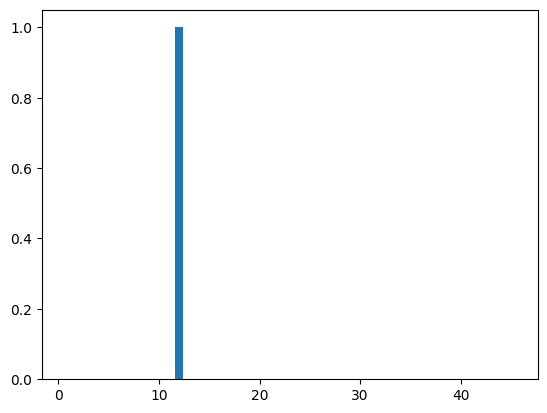

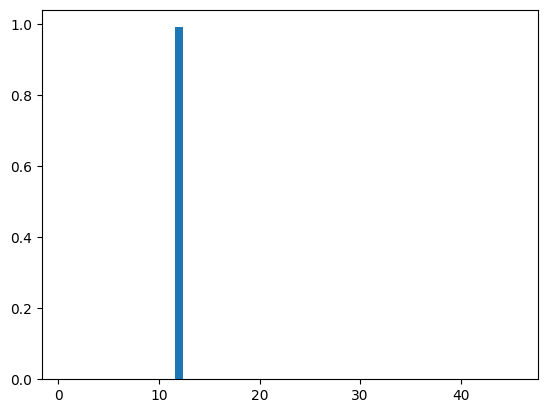

In [99]:
func = random.choice(Embeddings).unsqueeze(0).to(DEVICE)
pred = sigmoid(autoencoder(func.float()))


func = random.choice(Embeddings).unsqueeze(0).to(DEVICE)
pred = sigmoid(autoencoder(func.float()))

x_axis = np.linspace(1,45,45)

plt.bar(x_axis,func.squeeze().to('cpu').numpy())
plt.show()

plt.bar(x_axis,pred.squeeze().to('cpu').detach().numpy())
plt.show()

In [100]:
with open('ele2emb.pkl', 'rb') as f:
    ele2emb = pickle.load(f)

In [102]:
for i in ele2emb:
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107


In [104]:
len(ele2emb[91])

133